In [162]:
import pandas as pd
import numpy as np
import seaborn
import re
import os
import xgboost as xgb
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

from xgboost import plot_importance
from sklearn.model_selection import train_test_split

In [163]:
job_posting = pd.read_csv('csv/job_postings_training_set.csv')
print(job_posting.columns)
print(job_posting.shape)

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
(17828, 18)


## 將特徵區分為下述幾種類型
* 數值型 (numerical)
* 文本型 (textual)
* 類別型 (categorical)

In [164]:
Y = job_posting['fraudulent']
numerical = job_posting.select_dtypes(include=['number'])
textual = job_posting[['title', 'company_profile', 'description', 'requirements', 'benefits']]
categorical = job_posting.select_dtypes(include=['object']).drop(textual, axis=1)

In [165]:
print(f'fraudulent distribution: {Y.nunique()}\n')
print(f'categorical value distribution:\n\n {categorical.nunique()}\n')
print(f'numerical value distribution:\n\n {numerical.nunique()}\n')
print(f'textual value distribution:\n\n {textual.nunique()}\n')

fraudulent distribution: 2

categorical value distribution:

 location               3097
department             1337
salary_range            874
employment_type           5
required_experience       7
required_education       13
industry                131
function                 37
dtype: int64

numerical value distribution:

 job_id              17828
telecommuting           2
has_company_logo        2
has_questions           2
fraudulent              2
dtype: int64

textual value distribution:

 title              11188
company_profile     1707
description        14677
requirements       11881
benefits            6131
dtype: int64



### 將 value difference 數量少於 150 的做單因子 & 關聯性觀察

In [172]:
def feat_exploration(df, topN=5, data=job_posting):
    for feat in df:
        fig, (ax1, ax2) = plt.subplots(1, 2)

        # 單因子觀察
        ax1 = seaborn.countplot(x=feat, data=data, ax=ax1, order=data[feat].value_counts().iloc[:topN].index)
        ax1.tick_params(axis='x', labelrotation=90)

        # 關聯性觀察
        if feat == 'fraudulent':
            continue
        count_groupby_Y = (data.groupby([feat])['fraudulent']
                           .value_counts()
                           .rename('count')
                           .reset_index()
                           .sort_values('fraudulent'))
        total_count = data['fraudulent'].value_counts().rename('total')
        counts_ratio = pd.merge(count_groupby_Y, total_count, how='left', left_on='fraudulent', right_index=True)
        counts_ratio['ratio'] = counts_ratio['count'] / counts_ratio['total'] 
        ax2 = seaborn.barplot(x=feat, y="ratio", hue="fraudulent", data=counts_ratio, ax=ax2, order=data[feat].value_counts().iloc[:topN].index)
        ax2.tick_params(axis='x', labelrotation=90)
                

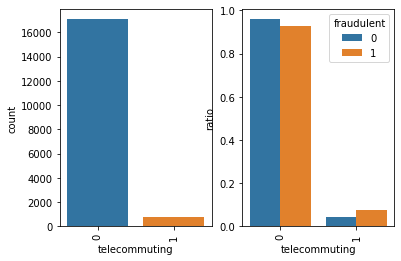

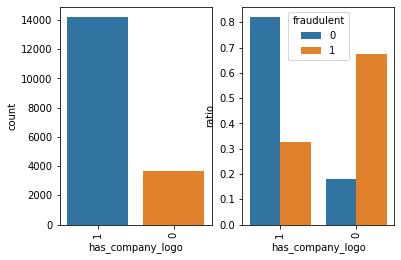

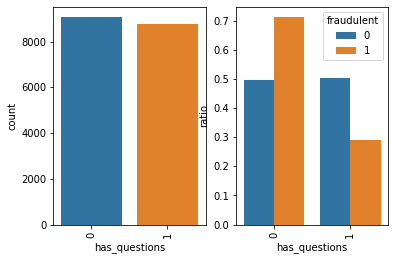

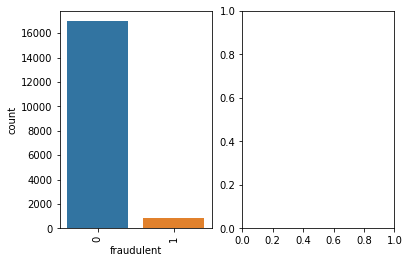

In [173]:
# Numerical features
critical = numerical.nunique() < 150
num_less150 = critical.index[critical]
feat_exploration(num_less150)

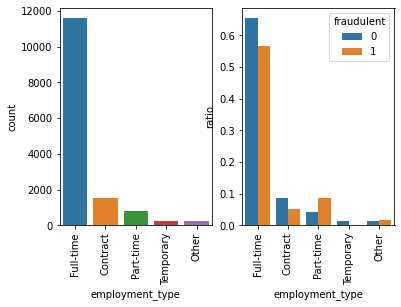

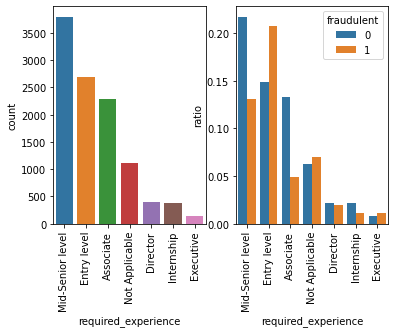

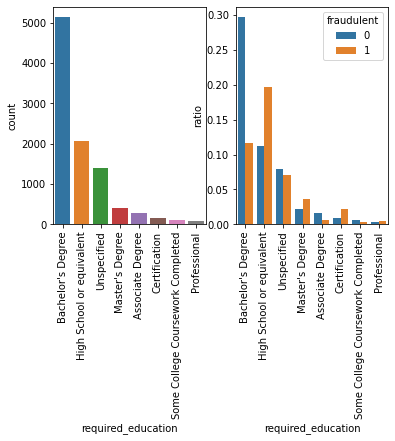

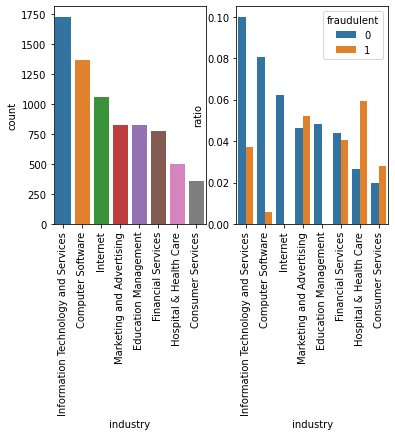

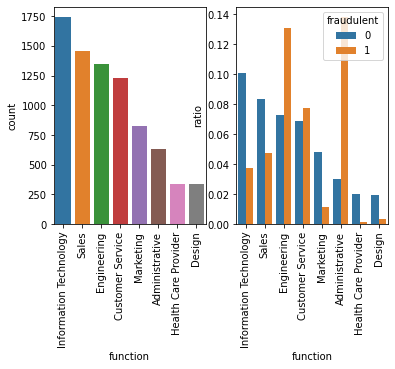

In [174]:
# Categorical features
critical = categorical.nunique() < 150
cate_less150 = critical.index[critical]
feat_exploration(cate_less150, topN=8)

### 將 value difference 大於 150 的 features 做各別前處理
* job_id -> 直接移除
* location -> `只取國家名稱`
* department -> 不調整
* salary_range -> `將薪資範圍平均，轉為數值型特徵`

In [175]:
# location
job_posting_pre = job_posting[:]
job_posting_pre['location'] = job_posting['location'].str.split(",", n=1, expand=True)[0]

# salary_range
salary = job_posting['salary_range'].str.split("-", n=1, expand=True)
def isnumber(x):
    try:
        float(x)
        return True
    except:
        return False
salary = salary[salary.applymap(isnumber)].astype('float32')
job_posting_pre['salary_range'] = (salary[0] + salary[1]) / 2

# job_id
job_posting_pre = job_posting_pre.drop('job_id', axis=1)

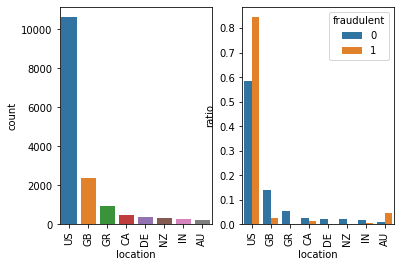

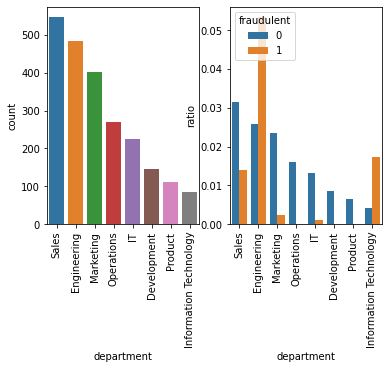

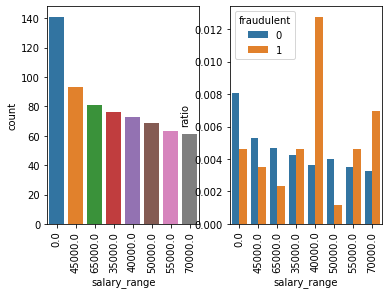

In [176]:
cate_large150 = ['location', 'department', 'salary_range']
feat_exploration(cate_large150, topN=8, data=job_posting_pre)

# TODO exploration
* 薪水的畫圖要調整為 binner

# TODO preprocess
1. Remove stop_word
2. Stemming
3. 類別轉數值